In [ ]:
import re
import random
import math
from collections import Counter
from tqdm import tqdm

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/naman/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


device(type='cuda')

In [4]:
class BPETokenizer:
    def __init__(self, vocab_size=20000):
        self.vocab_size = vocab_size
        self.merges = []
        self.token_to_id = {}
        self.id_to_token = {}

    def _preprocess(self, text):
        text = text.lower()
        text = re.sub(r"[^a-z0-9\s]", "", text)
        return text.split()

    def train(self, texts):
        vocab = Counter()
        for text in texts:
            for word in self._preprocess(text):
                vocab[tuple(list(word) + ["</w>"])] += 1

        def get_pair_stats(vocab):
            stats = Counter()
            for word, freq in vocab.items():
                for i in range(len(word) - 1):
                    stats[(word[i], word[i+1])] += freq
            return stats

        while True:
            stats = get_pair_stats(vocab)
            if not stats:
                break

            best = stats.most_common(1)[0][0]
            self.merges.append(best)

            new_vocab = {}
            for word, freq in vocab.items():
                new_word = []
                i = 0
                while i < len(word):
                    if i < len(word) - 1 and (word[i], word[i+1]) == best:
                        new_word.append(word[i] + word[i+1])
                        i += 2
                    else:
                        new_word.append(word[i])
                        i += 1
                new_vocab[tuple(new_word)] = freq

            vocab = new_vocab
            if len({sym for word in vocab for sym in word}) >= self.vocab_size:
                break

        tokens = sorted({sym for word in vocab for sym in word})
        self.token_to_id = {t: i for i, t in enumerate(tokens)}
        self.id_to_token = {i: t for t, i in self.token_to_id.items()}

    def encode(self, text):
        tokens = []
        for word in self._preprocess(text):
            symbols = list(word) + ["</w>"]
            for merge in self.merges:
                i = 0
                while i < len(symbols) - 1:
                    if (symbols[i], symbols[i+1]) == merge:
                        symbols[i:i+2] = ["".join(merge)]
                    else:
                        i += 1
            tokens.extend([self.token_to_id[s] for s in symbols if s in self.token_to_id])
        return tokens

    def decode(self, ids):
        return "".join(self.id_to_token[i] for i in ids).replace("</w>", " ")

In [7]:
wiki_path = "/home/naman/Cryptonite-RTP-NamanGoel/Task-0/archive/AllCombined.txt"

with open(wiki_path, encoding="utf-8") as f:
    wiki_sentences = [line.strip() for line in f if line.strip()]

wiki_sentences = wiki_sentences[:50000]
len(wiki_sentences)

50000

In [8]:
tokenizer = BPETokenizer(vocab_size=20000)
tokenizer.train(wiki_sentences)

vocab_size = len(tokenizer.token_to_id)
print("Final vocab size:", vocab_size)

Final vocab size: 20000


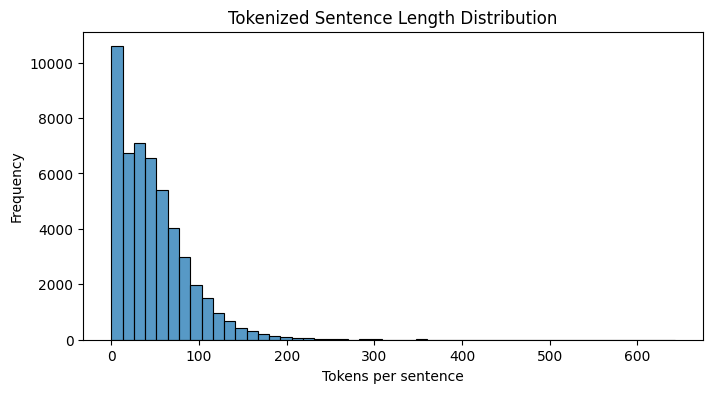

Mean length: 47.48924
95th percentile: 123.0


In [9]:
lengths = [len(tokenizer.encode(s)) for s in wiki_sentences]

plt.figure(figsize=(8,4))
sns.histplot(lengths, bins=50)
plt.title("Tokenized Sentence Length Distribution")
plt.xlabel("Tokens per sentence")
plt.ylabel("Frequency")
plt.show()

print("Mean length:", np.mean(lengths))
print("95th percentile:", np.percentile(lengths, 95))

In [10]:
token_counts = Counter()

for s in wiki_sentences:
    token_counts.update(tokenizer.encode(s))

unigram = np.zeros(vocab_size, dtype=np.float64)
for tid, c in token_counts.items():
    unigram[tid] = c

unigram = unigram ** 0.75
unigram /= unigram.sum()

unigram_dist = torch.tensor(unigram, device=DEVICE)

In [11]:
class CBOWDataset(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer, window):
        self.data = []
        for text in texts:
            tokens = tokenizer.encode(text)
            for i in range(window, len(tokens)-window):
                ctx = tokens[i-window:i] + tokens[i+1:i+window+1]
                self.data.append((ctx, tokens[i]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        c, t = self.data[idx]
        return torch.tensor(c), torch.tensor(t)

In [12]:
class CBOWNegSampling(nn.Module):
    def __init__(self, vocab_size, dim):
        super().__init__()
        self.in_embed = nn.Embedding(vocab_size, dim)
        self.out_embed = nn.Embedding(vocab_size, dim)

        nn.init.uniform_(self.in_embed.weight, -0.5/dim, 0.5/dim)
        nn.init.zeros_(self.out_embed.weight)

    def forward(self, ctx, target, neg):
        v = self.in_embed(ctx).mean(dim=1)
        pos = torch.sum(v * self.out_embed(target), dim=1)
        neg_score = torch.bmm(self.out_embed(neg), v.unsqueeze(2)).squeeze(2)

        loss = -(
            torch.log(torch.sigmoid(pos) + 1e-9) +
            torch.sum(torch.log(torch.sigmoid(-neg_score) + 1e-9), dim=1)
        )
        return loss.mean()

In [13]:
EMBED_DIM = 384

WINDOW = 5
#Small (2–3)	Learns grammar & syntax
#Medium (5–8)	Learns semantics (best for sentiment)
#Very large (15+)	Learns topic, loses sentiment

NEG_K = 5
#CBOW learns by:
#   Pulling correct context–target pairs closer
#   Pushing random pairs away
#K controls: “How many wrong examples do we show per correct one?”
#Small (2–5)	Fast, rough embeddings
#Medium (5–10)	Sharper semantic separation
#Very large (20+)	Slow, diminishing returns

BATCH = 512
EPOCHS = 20

dataset = CBOWDataset(wiki_sentences, tokenizer, WINDOW)
loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH, shuffle=True)

model = CBOWNegSampling(vocab_size, EMBED_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses = []

for e in range(EPOCHS):
    total = 0
    for ctx, tgt in tqdm(loader):
        ctx, tgt = ctx.to(DEVICE), tgt.to(DEVICE)
        neg = torch.multinomial(unigram_dist, tgt.size(0)*NEG_K, True).view(tgt.size(0), NEG_K)

        optimizer.zero_grad()
        loss = model(ctx, tgt, neg)
        loss.backward()
        optimizer.step()
        total += loss.item()

    avg = total / len(loader)
    losses.append(avg)
    print(f"Epoch {e+1} | Loss {avg:.4f}")

100%|██████████| 3781/3781 [00:33<00:00, 112.10it/s]


Epoch 1 | Loss 2.4209


100%|██████████| 3781/3781 [00:32<00:00, 115.10it/s]


Epoch 2 | Loss 2.0015


100%|██████████| 3781/3781 [00:31<00:00, 120.47it/s]


Epoch 3 | Loss 1.8107


100%|██████████| 3781/3781 [00:29<00:00, 126.37it/s]


Epoch 4 | Loss 1.6819


100%|██████████| 3781/3781 [00:34<00:00, 110.84it/s]


Epoch 5 | Loss 1.5810


100%|██████████| 3781/3781 [00:33<00:00, 113.81it/s]


Epoch 6 | Loss 1.4963


100%|██████████| 3781/3781 [00:32<00:00, 117.16it/s]


Epoch 7 | Loss 1.4206


100%|██████████| 3781/3781 [00:31<00:00, 121.38it/s]


Epoch 8 | Loss 1.3499


100%|██████████| 3781/3781 [00:32<00:00, 117.99it/s]


Epoch 9 | Loss 1.2858


100%|██████████| 3781/3781 [00:32<00:00, 117.90it/s]


Epoch 10 | Loss 1.2262


100%|██████████| 3781/3781 [00:30<00:00, 124.44it/s]


Epoch 11 | Loss 1.1684


100%|██████████| 3781/3781 [00:29<00:00, 126.25it/s]


Epoch 12 | Loss 1.1138


100%|██████████| 3781/3781 [00:31<00:00, 119.59it/s]


Epoch 13 | Loss 1.0640


100%|██████████| 3781/3781 [00:33<00:00, 113.67it/s]


Epoch 14 | Loss 1.0181


100%|██████████| 3781/3781 [00:33<00:00, 113.42it/s]


Epoch 15 | Loss 0.9747


100%|██████████| 3781/3781 [00:31<00:00, 119.89it/s]


Epoch 16 | Loss 0.9359


100%|██████████| 3781/3781 [00:30<00:00, 123.83it/s]


Epoch 17 | Loss 0.8999


100%|██████████| 3781/3781 [00:32<00:00, 115.19it/s]


Epoch 18 | Loss 0.8662


100%|██████████| 3781/3781 [00:32<00:00, 115.19it/s]


Epoch 19 | Loss 0.8383


100%|██████████| 3781/3781 [00:30<00:00, 123.16it/s]

Epoch 20 | Loss 0.8094


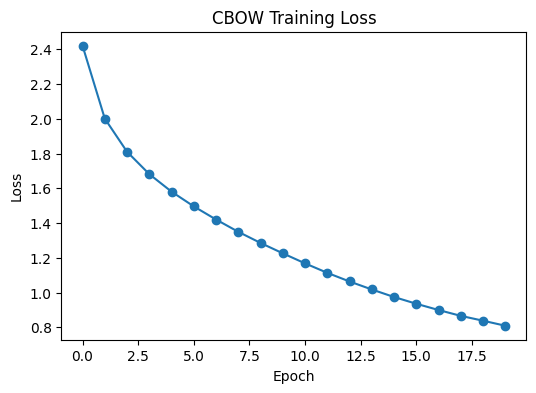

In [14]:
plt.figure(figsize=(6,4))
plt.plot(losses, marker="o")
plt.title("CBOW Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [15]:
embeddings = model.in_embed.weight.detach().cpu().numpy()

In [16]:
pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [18]:
texts = []
labels = []

label_map = {
    "negative": 0,
    "neutral": 1,
    "positive": 2
}

bad_lines = 0

with open(
    "/home/naman/Cryptonite-RTP-NamanGoel/Task-0/Sentences_AllAgree.txt",
    encoding="latin-1"
) as f:
    for line in f:
        line = line.strip()
        if not line:
            continue

        # Each line: <sentence>@<label>
        if "@" not in line:
            bad_lines += 1
            continue

        sentence, label = line.rsplit("@", 1)
        label = label.strip().lower()

        if label not in label_map:
            bad_lines += 1
            continue

        texts.append(sentence.strip())
        labels.append(label_map[label])

texts = np.array(texts)
labels = np.array(labels, dtype=np.int64)

print("Samples loaded:", len(texts))
print("Label distribution:", np.bincount(labels))

'''0 = negative → 303

1 = neutral → 1391

2 = positive → 570'''

print("Skipped malformed lines:", bad_lines)

Samples loaded: 2264
Label distribution: [ 303 1391  570]
Skipped malformed lines: 0


In [19]:
def doc_vector(text):
    ids = tokenizer.encode(text)
    if not ids:
        return np.zeros(EMBED_DIM)
    return embeddings[ids].mean(axis=0)

X = np.vstack([doc_vector(t) for t in texts])
y = labels


In [20]:
clf = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1 #Use all CPU cores
)
clf.fit(X, y)

preds = clf.predict(X)
print("CBOW + LR Macro F1:", f1_score(y, preds, average="macro"))


CBOW + LR Macro F1: 0.8651368176260251


In [21]:
'''Logistic Regression learns by iterative optimization.
    This means:
        It slowly adjusts weights
        Each adjustment = one iteration

    max_iter=1000 means:
    If it hasn’t converged by 1000 steps, stop anyway.'''

'Logistic Regression learns by iterative optimization.\n    This means:\n        It slowly adjusts weights\n        Each adjustment = one iteration\n\n    max_iter=1000 means:\n    If it hasn’t converged by 1000 steps, stop anyway.'

In [22]:
'''class_weight = "balanced"

    The dataset has:
        Many neutral
        Fewer negative
        Medium positive

Without balancing:
Model would “play safe”
Predict neutral most of the time

Balanced weights mean:
“Misclassifying a rare class is penalized more.”

This directly improves macro F1.'''

'class_weight = "balanced"\n\n    The dataset has:\n        Many neutral\n        Fewer negative\n        Medium positive\n\nWithout balancing:\nModel would “play safe”\nPredict neutral most of the time\n\nBalanced weights mean:\n“Misclassifying a rare class is penalized more.”\n\nThis directly improves macro F1.'

In [23]:
sid = SentimentIntensityAnalyzer()

def vader_pred(t):
    c = sid.polarity_scores(t)["compound"]
    if c > 0.05: return 2
    if c < -0.05: return 0
    return 1
'''
compound is VADER’s final overall sentiment score.

Range: –1.0 to +1.0

Negative → negative sentiment

Positive → positive sentiment

Near zero → neutral sentiment
c is NOT a hyperparameter.
It is just a variable name holding that score.

Why the thresholds ±0.05?

These come from VADER’s original paper and documentation.

Rules:
c > 0.05 → positive
c < -0.05 → negative
otherwise → neutral
THAT IS WHY IT PERFORMS WORSE BECAUSE WE ARE NOT TUNING IT'''
v_preds = np.array([vader_pred(t) for t in texts])
print("VADER Macro F1:", f1_score(y, v_preds, average="macro"))


VADER Macro F1: 0.4866877018508586


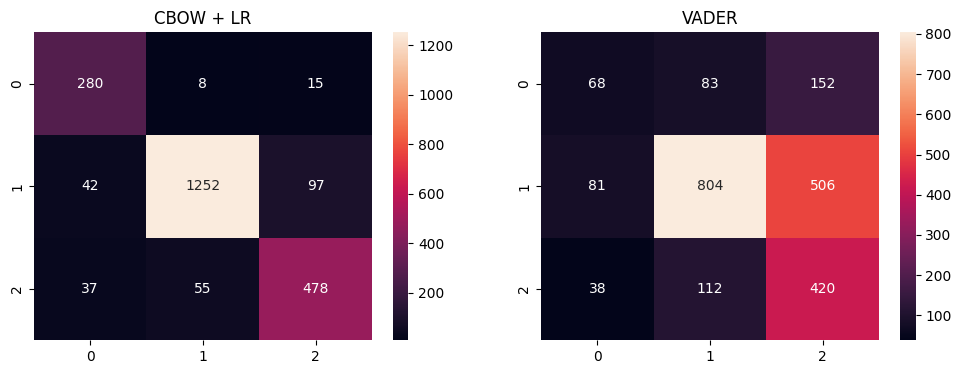

In [24]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

sns.heatmap(confusion_matrix(y, preds), annot=True, fmt="d", ax=ax[0])
ax[0].set_title("CBOW + LR")

sns.heatmap(confusion_matrix(y, v_preds), annot=True, fmt="d", ax=ax[1])
ax[1].set_title("VADER")

plt.show()


In [25]:
def build_sentence_vector(text, pooling="mean"):
    ids = tokenizer.encode(text)
    if not ids:
        return np.zeros(EMBED_DIM)

    vecs = embeddings[ids]

    if pooling == "mean":
        return vecs.mean(axis=0)

    elif pooling == "tfidf":
        weights = []
        for i in ids:
            weights.append(idf.get(i, 0.0))
        weights = np.array(weights)
        if weights.sum() == 0:
            return vecs.mean(axis=0)
        return np.average(vecs, axis=0, weights=weights)

    else:
        raise ValueError("Unknown pooling method")

In [26]:
# User Input Classification
label_map_inv = {0: "Negative", 1: "Neutral", 2: "Positive"}

def classify_text(text, pooling="mean"):
    vec = build_sentence_vector(text, pooling=pooling)
    pred = clf.predict(vec.reshape(1, -1))[0]
    return label_map_inv[pred]

In [27]:
# Sanity check before inference
required_vars = ["tokenizer", "embeddings", "clf", "EMBED_DIM"]

for v in required_vars:
    if v not in globals():
        raise RuntimeError(
            f"Required object '{v}' is not defined. "
            "Make sure all training cells have been run."
        )

print("All required objects are available. Ready for inference.")

All required objects are available. Ready for inference.


In [28]:
while True:
    s = input("Enter financial sentence (or 'q' to quit): ")
    if s.lower() == "q":
        break
    print("Prediction:", classify_text(s, pooling="mean"))
    print("-" * 50)

Prediction: Negative
--------------------------------------------------
Prediction: Negative
--------------------------------------------------


In [29]:
# Random Financial Sentence Demo
import random

def random_demo(n=5, pooling="mean"):
    samples = random.sample(list(texts), n)
    for s in samples:
        print("Sentence:", s)
        print("Prediction:", classify_text(s, pooling=pooling))
        print("-" * 50)

random_demo()

Sentence: Cargotec Germany GmbH has been awarded a contract by Stadtverwaltung Mainz for chassis bodies under Open procedure .
Prediction: Positive
--------------------------------------------------
Sentence: Both operating profit and turnover for the six-month period increased , respectively from EUR0 .1 m and EUR29 .0 m , as compared to the corresponding period a year ago .
Prediction: Positive
--------------------------------------------------
Sentence: Work on the assignment has already started and is due for completion in spring 2011 .
Prediction: Neutral
--------------------------------------------------
Sentence: Officials did not disclose the contract value .
Prediction: Neutral
--------------------------------------------------
Sentence: 561,470 new shares under 2003 option rights plan Packaging company Huhtamaki Oyj reported on Monday that a total of 561,470 new shares of the company have been issued based on share subscriptions under its 2003 option rights plan .
Prediction:

In [30]:
# SEMANTIC ANALOGY TEST
def cosine_similarity(vec, mat):
    vec_norm = vec / (np.linalg.norm(vec) + 1e-9)
    mat_norm = mat / (np.linalg.norm(mat, axis=1, keepdims=True) + 1e-9)
    return np.dot(mat_norm, vec_norm)

In [31]:
def analogy(word_a, word_b, word_c, top_k=5):
    def get_token_id(word):
        ids = tokenizer.encode(word)
        return ids[0] if ids else None

    a = get_token_id(word_a)
    b = get_token_id(word_b)
    c = get_token_id(word_c)

    if None in (a, b, c):
        print("One or more words not in vocabulary")
        return

    vec = embeddings[a] - embeddings[b] + embeddings[c]
    sims = cosine_similarity(vec, embeddings)

    best = sims.argsort()[-top_k:][::-1]
    for i in best:
        print(tokenizer.id_to_token[i], sims[i])

In [32]:
# TF-IDF WEIGHTED MEAN
from math import log

doc_freq = Counter()
N = len(texts)

for s in texts:
    ids = set(tokenizer.encode(s))
    for i in ids:
        doc_freq[i] += 1

idf = {}
for token_id, df in doc_freq.items():
    idf[token_id] = log((N + 1) / (df + 1))


In [33]:
X_tfidf = np.vstack([
    build_sentence_vector(t, pooling="tfidf")
    for t in texts
])

clf_tfidf = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)
clf_tfidf.fit(X_tfidf, labels)

preds_tfidf = clf_tfidf.predict(X_tfidf)

print("TF-IDF Weighted Mean Macro F1:",
      f1_score(labels, preds_tfidf, average="macro"))


TF-IDF Weighted Mean Macro F1: 0.8476022553136113


In [34]:
print("MEAN pooling:")
random_demo(pooling="mean")

print("\nTF-IDF pooling:")
random_demo(pooling="tfidf")


MEAN pooling:
Sentence: Jun. 25 , 2008 ( Boy Genius Report delivered by Newstex ) -- The Nokia ( NYSE : NOK ) N78 , huh ?
Prediction: Neutral
--------------------------------------------------
Sentence: Finnish Rautaruukki has been awarded a contract to supply and install steel superstructures for the Partihallsf+Ârbindelsen bridge in Gothenburg in Sweden .
Prediction: Positive
--------------------------------------------------
Sentence: In the building and home improvement trade , net sales totalled EUR 1,173 mn , down from EUR 1,566 mn a year earlier .
Prediction: Negative
--------------------------------------------------
Sentence: ADPnews - Feb 5 , 2010 - Finnish real estate investor Sponda Oyj HEL : SDA1V said today that it slipped to a net loss of EUR 81.5 million USD 11.8 m in 2009 from a profit of EUR 29.3 million in 2008 .
Prediction: Negative
--------------------------------------------------
Sentence: The business development initiatives in North America are headed by Lynn S

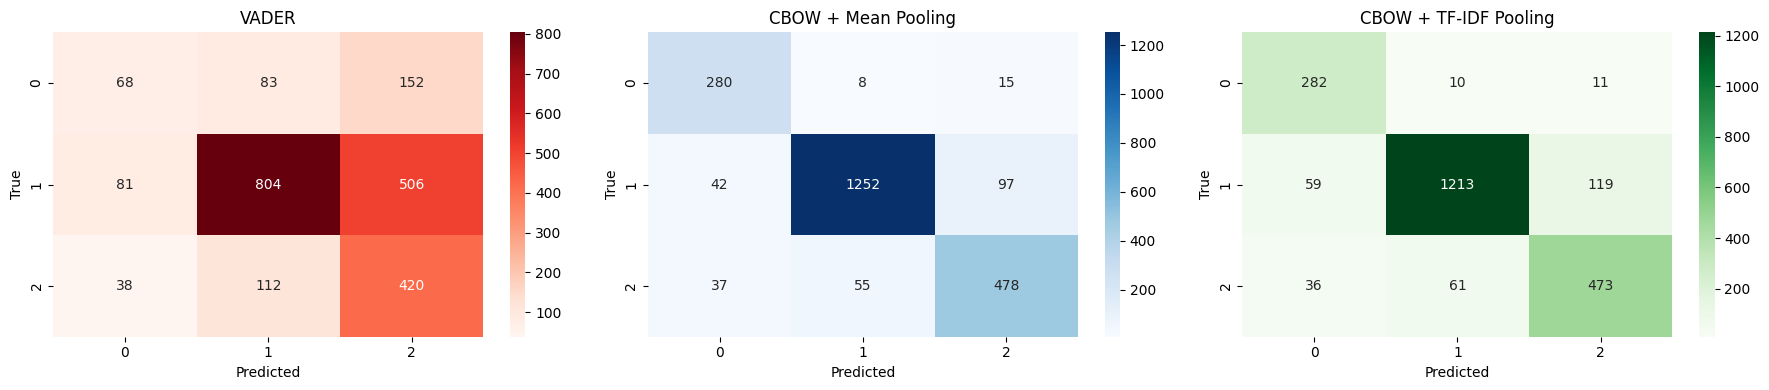

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_vader = confusion_matrix(labels, v_preds)
cm_mean  = confusion_matrix(labels, preds)
cm_tfidf = confusion_matrix(labels, preds_tfidf)

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sns.heatmap(cm_vader, annot=True, fmt="d", ax=axes[0], cmap="Reds")
axes[0].set_title("VADER")

sns.heatmap(cm_mean, annot=True, fmt="d", ax=axes[1], cmap="Blues")
axes[1].set_title("CBOW + Mean Pooling")

sns.heatmap(cm_tfidf, annot=True, fmt="d", ax=axes[2], cmap="Greens")
axes[2].set_title("CBOW + TF-IDF Pooling")

for ax in axes:
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()
plt.show()


In [37]:
def analogy(a, b, c, top_k=5):
    def tok(word):
        ids = tokenizer.encode(word)
        return ids[0] if ids else None

    ia, ib, ic = tok(a), tok(b), tok(c)
    if None in (ia, ib, ic):
        print("Token not found")
        return

    vec = embeddings[ia] - embeddings[ib] + embeddings[ic]

    norms = np.linalg.norm(embeddings, axis=1) * np.linalg.norm(vec)
    sims = embeddings @ vec / (norms + 1e-9)

    best = sims.argsort()[-top_k:][::-1]
    for i in best:
        print(f"{tokenizer.id_to_token[i]:<15} {sims[i]:.3f}")


In [38]:
print("king - man + woman")
analogy("king", "man", "woman")

print("\nparis - france + germany")
analogy("paris", "france", "germany")

print("\nprofit - increase + loss")
analogy("profit", "increase", "loss")


king - man + woman
king</w>        0.650
woman</w>       0.577
queen</w>       0.376
monarch</w>     0.366
uterus</w>      0.350

paris - france + germany
paris</w>       0.655
germany</w>     0.635
frankfurt</w>   0.375
africanamericans</w> 0.341
moscow</w>      0.314

profit - increase + loss
profit</w>      0.558
loss</w>        0.446
middles         0.353
subtraction</w> 0.309
diocese</w>     0.293


In [39]:
num_tokens = len(tokenizer.token_to_id)
print("Number of BPE tokens:", num_tokens)


Number of BPE tokens: 20000


In [40]:
lengths = [len(tokenizer.encode(s)) for s in wiki_sentences]

print("Avg tokens per sentence:", np.mean(lengths))
print("95th percentile:", np.percentile(lengths, 95))


Avg tokens per sentence: 47.48924
95th percentile: 123.0


In [41]:
import pickle

with open("bpe_tokenizer_5_5.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

np.save("cbow_embeddings_5_5.npy", embeddings)

with open("bpe_tokenizer_5_5.pkl", "rb") as f:
    tokenizer = pickle.load(f)

embeddings = np.load("cbow_embeddings_5_5.npy")